<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/ImagePainterNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Painter
The aim of this notebook is to:

* Load a picture
* Create a feed-forward Neural Network
* Use the NN to "learn" the picture as a colour (RGB) distribution over the (x,y) pixel coordinates
* Use the trained NN to "paint back" the original picture

Is this overfitting? Yes! So what's the value added?

The value added is that (hopefully) what we will have achieved is a compact (in terms of parameters needed to be saved on disk) approximator of any given picture!

## Import packages preamble

In [2]:
import pandas as pd
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output
import tensorflow as tf
from tensorflow import keras
import skimage
from PIL import Image
import argparse
import imutils
from google.colab.patches import cv2_imshow

### Function definitions

In [3]:
def create_NN_2(nnodes):
    ### This function neatly wraps the construction of the NN
    # It returns a Keras TF model
    
    # Inputs are X, Y coordinates
    ninputs = 2
    # Outputs are the R, G, B channels for the desired pixel
    noutputs = 3
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(ninputs,)))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(nnodes, activation='relu'))
    model.add(tf.keras.layers.Dense(noutputs))
    
    return model



### Load image

Saving escher_original.jpg to escher_original.jpg


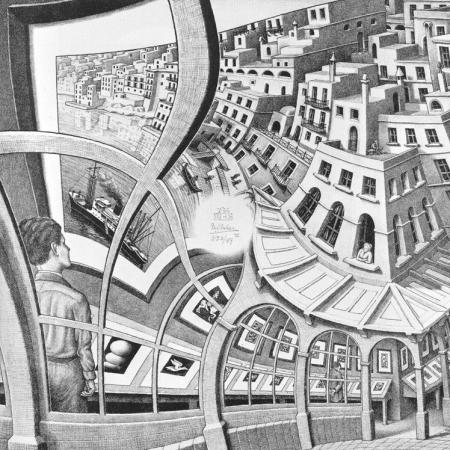

In [5]:
# upload files from disk
from google.colab import files
uploaded = files.upload()

fname = 'escher_original.jpg' #TO CHANGE

# load the image from disk
image = cv2.imread(fname)
# show image
cv2_imshow(image)

### Convert raw image in X and Y inputs for the NN

In [6]:
# The X input for the NN is a tuple of (x,y) pixel coordinates
# The Y input is the (r, g, b) tuple

height = len(image)
width = len(image[0])

# X (coordinates) and Y (rgb) data
X = []
Y = []

# The idea is to:
# 1) Loop over the x and y coordinates of the picture
# 2) Save the (x, y) tuple and the RGB tuple in the separate lists
for x in range(0, width):
    for y in range(0, height):
        X.append((x, y))
        Y.append(image[y][x])

# The last step is to transform the x and y lists as Numpy arrays
# This is necessary to feed the Keras model
x_np = np.asarray(X)
y_np = np.asarray(Y)

### Create Keras NN

In [7]:
num_nodes = 2000
model = create_NN_2(num_nodes)
model.compile(loss=tf.keras.losses.MeanSquaredError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics=['accuracy'])

### Train the Keras NN

In [8]:
model.fit(x_np, y_np, epochs=200, batch_size=1000, shuffle = True)


Epoch 1/100
2025/2025 [==============================] - 146s 72ms/step - loss: 5147819.4978 - accuracy: 0.3362
Epoch 2/100
2025/2025 [==============================] - 146s 72ms/step - loss: 3144.6050 - accuracy: 0.2946
Epoch 3/100
2025/2025 [==============================] - 145s 72ms/step - loss: 3087.8275 - accuracy: 0.2849
Epoch 4/100
2025/2025 [==============================] - 145s 72ms/step - loss: 2999.9591 - accuracy: 0.2308
Epoch 5/100
2025/2025 [==============================] - 146s 72ms/step - loss: 3033.8672 - accuracy: 0.2302
Epoch 6/100
2025/2025 [==============================] - 145s 72ms/step - loss: 3127.8039 - accuracy: 0.2718
Epoch 7/100
2025/2025 [==============================] - 144s 71ms/step - loss: 3205.6924 - accuracy: 0.2991
Epoch 8/100
2025/2025 [==============================] - 144s 71ms/step - loss: 3183.8866 - accuracy: 0.2841
Epoch 9/100
2025/2025 [==============================] - 144s 71ms/step - loss: 3120.2571 - accuracy: 0.3727
Epoch 10/100
202

### Obtain the "painted" picture according to the NN
Note that this is equivalent to asking for a "prediction" of the RGB tuple for every pixel coordinate of the original image.

If you are not convinced, look at the fact that we are calling _model.predict(x_np)_, where _x_np_ is the same X input vector we have provided during training, i.e. spanning the whole picture.

In [9]:
image_according_to_nn = model.predict(x_np)

In [10]:
# Matplotlib, in order to show the image, requires to convert back the NN prediction from a Numpy array to a list of lists
# In particular, note how the list of lists is indexed by 1) The Y coordinate 2) The X coordinate, not X and then Y!

new_image = []

for y in range(0, height):
    new_image.append([])
    for x in range(0, width):
        new_image[y].append(image_according_to_nn[y + height * x].tolist())
        new_image[y][x] = [int(i) for i in new_image[y][x]]


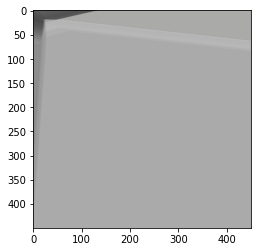

In [11]:
# Let's show the picture!
plt.imshow(new_image)

### Save model weights (optional)

In [ ]:
model.save_weights("model_weights_v1.mw")